In [2]:
#Made by: Leonardo Sole Luigi Scotto Rosato
#From: University of naples Federico II
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import networkx as nx
import matplotlib.pyplot as plt
import math
import time
import seaborn as sns
import pandas as pd

In [3]:
import os
#Controllo della cartella per vedere i file presenti
folder_path = "Istanza_A"
file_list = os.listdir(folder_path)
#debug
#print(file_list)


In [4]:

# Specifica il percorso relativo del file .vrp
file_path = "Istanza_A\A-n32-k5.vrp" 
with open(file_path, "r") as file:
    # Leggi il contenuto del file
    file_content = file.read()
    print(file_content)

NAME : A-n32-k5
COMMENT : (Augerat et al, No of trucks: 5, Optimal value: 784)
TYPE : CVRP
DIMENSION : 32
EDGE_WEIGHT_TYPE : EUC_2D 
CAPACITY : 100
NODE_COORD_SECTION 
 1 82 76
 2 96 44
 3 50 5
 4 49 8
 5 13 7
 6 29 89
 7 58 30
 8 84 39
 9 14 24
 10 2 39
 11 3 82
 12 5 10
 13 98 52
 14 84 25
 15 61 59
 16 1 65
 17 88 51
 18 91 2
 19 19 32
 20 93 3
 21 50 93
 22 98 14
 23 5 42
 24 42 9
 25 61 62
 26 9 97
 27 80 55
 28 57 69
 29 23 15
 30 20 70
 31 85 60
 32 98 5
DEMAND_SECTION 
1 0 
2 19 
3 21 
4 6 
5 19 
6 7 
7 12 
8 16 
9 6 
10 16 
11 8 
12 14 
13 21 
14 16 
15 3 
16 22 
17 18 
18 19 
19 1 
20 24 
21 8 
22 12 
23 4 
24 8 
25 24 
26 24 
27 2 
28 20 
29 15 
30 2 
31 14 
32 9 
DEPOT_SECTION 
 1  
 -1  
EOF 



In [5]:
# Inizializza le variabili
capacity = None #Capacita dei veicoli
node_coord_section = [] #Coordinate dei nodi
demand_section = [] #Richieste dei nodi
depot_section = [] #Sezione del deposito
num_vehicl = 0 #Numero di veicoli

# Flag per determinare quando leggere i dati della sezione "DEMAND_SECTION"
read_demand = False

# Flag per determinare quando leggere i dati della sezione "DEPOT_SECTION"
read_depot = False

# Leggi il file e analizza le righe
with open(file_path, "r") as file:
    for line in file:
        line = line.strip()
        if line.startswith("COMMENT"):
            comment_line = line
        #Se la riga inizia con CAPACITY, mettiamo nelle capacità
        elif line.startswith("CAPACITY"):
            _, capacity = line.split(":")
            capacity = int(capacity.strip())
        elif line.startswith("NODE_COORD_SECTION"):
            # Leggi le coordinate dei nodi fino alla sezione DEMAND_SECTION
            for line in file:
                line = line.strip()
                if line == "DEMAND_SECTION":
                    read_demand = True
                    break
                node_id, x, y = map(int, line.split())
                node_coord_section.append((node_id, x, y))
        elif read_demand:
            if line == "DEPOT_SECTION":
                # Fine della sezione DEMAND_SECTION, inizia la sezione DEPOT_SECTION
                read_demand = False
                read_depot = True
            else:
                node_id, demand = map(int, line.split())
                demand_section.append((node_id, demand))
        elif read_depot:
            if line == "EOF":
                # Fine della sezione DEPOT_SECTION
                read_depot = False
            else:
                depot_id = int(line)
                depot_section.append(depot_id)
# Estrai il valore di "No of trucks" dalla linea COMMENT
start_index = comment_line.find("No of trucks:") + len("No of trucks:")
end_index = comment_line.find(",", start_index)
num_vehicl = int(comment_line[start_index:end_index].strip())

# Stampa i risultati
print("Number of vehicles:", num_vehicl)
print("Capacity:", capacity)
print("Node Coord Section:")
for node in node_coord_section:
    print(node)
print("Demand Section:")
for node in demand_section:
    print(node)
print("Depot Section:")
for depot in depot_section:
    print(depot)

Number of vehicles: 5
Capacity: 100
Node Coord Section:
(1, 82, 76)
(2, 96, 44)
(3, 50, 5)
(4, 49, 8)
(5, 13, 7)
(6, 29, 89)
(7, 58, 30)
(8, 84, 39)
(9, 14, 24)
(10, 2, 39)
(11, 3, 82)
(12, 5, 10)
(13, 98, 52)
(14, 84, 25)
(15, 61, 59)
(16, 1, 65)
(17, 88, 51)
(18, 91, 2)
(19, 19, 32)
(20, 93, 3)
(21, 50, 93)
(22, 98, 14)
(23, 5, 42)
(24, 42, 9)
(25, 61, 62)
(26, 9, 97)
(27, 80, 55)
(28, 57, 69)
(29, 23, 15)
(30, 20, 70)
(31, 85, 60)
(32, 98, 5)
Demand Section:
(1, 0)
(2, 19)
(3, 21)
(4, 6)
(5, 19)
(6, 7)
(7, 12)
(8, 16)
(9, 6)
(10, 16)
(11, 8)
(12, 14)
(13, 21)
(14, 16)
(15, 3)
(16, 22)
(17, 18)
(18, 19)
(19, 1)
(20, 24)
(21, 8)
(22, 12)
(23, 4)
(24, 8)
(25, 24)
(26, 24)
(27, 2)
(28, 20)
(29, 15)
(30, 2)
(31, 14)
(32, 9)
Depot Section:
1
-1


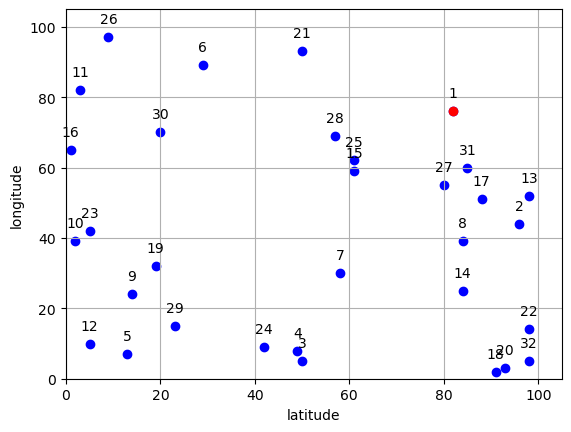

In [14]:
# Estrarre le coordinate dei nodi dal Node Coord Section
node_coord = [(x, y) for _, x, y in node_coord_section]

# Crea una figura e un grafico
fig, ax = plt.subplots()

# Plotta i punti dei nodi come puntini blu
ax.scatter(*zip(*node_coord), color='blue')

# Identifica il nodo 1 e plottalo come un puntino rosso
node_1_coord = node_coord[0]
ax.scatter(*node_1_coord, color='red')

# Aggiungi etichette ai punti dei nodi
for i, (x, y) in enumerate(node_coord):
    ax.annotate(str(i+1), (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Imposta i limiti dell'asse x e y
ax.set_xlim(0, 105)
ax.set_ylim(0, 105)

#Nome sugli assi
plt.xlabel('latitude')
plt.ylabel('longitude')

plt.grid()
# Mostra il grafico
plt.show()


In [7]:
def calculate_distance(x1, y1, x2, y2):
    """Calcola la distanza euclidea tra due punti."""
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    #return round(distance,2) #Arrotondo i risultati a due cifre decimali
    return round(distance) #Arrotondo i risultati a intero

def create_distance_matrix(node_coord_section):
    """Crea la matrice delle distanze basata sulle coordinate dei nodi."""
    num_nodes = len(node_coord_section)
    distance_matrix = [[0] * num_nodes for _ in range(num_nodes)]

    for i in range(num_nodes):
        x1, y1 = node_coord_section[i][1], node_coord_section[i][2]
        for j in range(num_nodes):
            x2, y2 = node_coord_section[j][1], node_coord_section[j][2]
            distance = calculate_distance(x1, y1, x2, y2)
            distance_matrix[i][j] = distance

    return distance_matrix

distance_matrix = create_distance_matrix(node_coord_section)

# # Stampa la matrice delle distanze
# for row in distance_matrix:
#        print(row)


In [8]:
def create_data_model(distance_matrix, demand_section, capacity, num_vehicl):
    """Stores the data for the problem."""
    data = {}
    demand_data= []
    for item in demand_section:
        demand_data.append(item[1])
    data['distance_matrix'] = distance_matrix
    data['demands'] = demand_data
    data['vehicle_capacities'] = [capacity]* num_vehicl
    data['num_vehicles'] = num_vehicl
    data['depot'] = 0
    return data
#debug
# data= create_data_model(distance_matrix,demand_section,capacity,num_vehicl)
# for row in data['distance_matrix']:
#     print(row)
# print("Demands:")
# print(data['demands'])
# print("Vehicle Capacities:")
# print(data['vehicle_capacities'])
# print("Number of Vehicles:")
# print(data['num_vehicles'])
# print("Depot:")
# print(data['depot'])

In [9]:
def print_solution(data, manager, routing, solution, execution_time):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id+1)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index+1, route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))
    print('Total Execution Time: {}s'.format(execution_time))
    return total_distance



In [15]:
def get_routes_from_solution(solution,FS,LSM):
    # Ottenere tutte le route dalla soluzione
    routes=[]
    for vehicle_id in range(data['num_vehicles']):
        route = []
        index = routing.Start(vehicle_id)
        while not routing.IsEnd(index):
            node = manager.IndexToNode(index)
            route.append(node)
            index = solution.Value(routing.NextVar(index))
        routes.append(route)

    # Stampa le route
    #for i, route in enumerate(routes):
    # print(f"Route for vehicle {i}:")
    # for node in route:
    #    print(node)


    # Estrarre le coordinate dei nodi dal Node Coord Section
    node_coord = [(x, y) for _, x, y in node_coord_section]

    # Crea una figura e un grafico
    fig, ax = plt.subplots()

    # Plotta i punti dei nodi come puntini blu
    ax.scatter(*zip(*node_coord), color='blue')

    # Identifica il nodo 1 e plottalo come un puntino rosso
    node_1_coord = node_coord[0]
    ax.scatter(*node_1_coord, color='red')

    # Aggiungi etichette ai punti dei nodi
    for i, (x, y) in enumerate(node_coord):
        ax.annotate(str(i+1), (x, y), textcoords="offset points", xytext=(0,10), ha='center')

    # Lista dei colori per le route
    colors = ['green', 'red', 'blue', 'orange', 'purple']

    #             # Plotta le route come collegamenti tra i nodi
    #             for i, route in enumerate(routes):
    #                 # Estrae le coordinate dei nodi nella route
    #                 route_coords = [node_coord[node_id] for node_id in route]

    #                 # Seleziona il colore corrispondente alla route
    #                 color = colors[i % len(colors)]

    #                 # Plotta la route come linea
    #                 line, = ax.plot(*zip(*route_coords), color=color)
    #                 line.set_label(f'Route {i+1}')  # Imposta l'etichetta per la linea

    # Plotta le route come collegamenti tra i nodi
    for i, route in enumerate(routes):
        # Estrae le coordinate dei nodi nella route
        route_coords = [node_coord[node_id] for node_id in route]

        # Aggiungi il nodo di partenza come ultimo punto nella lista delle coordinate
        route_coords.append(node_coord[0])

        # Seleziona il colore corrispondente alla route
        color = colors[i % len(colors)]

        # Plotta la route come linea
        line, = ax.plot(*zip(*route_coords), color=color)
        line.set_label(f'Route {i+1}')  # Imposta l'etichetta per la linea

    #titolo Grafico
    titolo=FS + " & " + LSM
    plt.title(titolo)
        
    # Imposta i limiti dell'asse x e y
    ax.set_xlim(0, 105)
    ax.set_ylim(0, 105)

    #Nome sugli assi
    plt.xlabel('latitude')
    plt.ylabel('longitude')
    plt.grid()
    #Legenda
    plt.legend(loc='upper right', fontsize= 8)
    # Mostra il grafico
    plt.show()

In [16]:
def create_solution_model(execution_time,total_distance):
    """Stores the data for the problem."""
    sol = {}
    sol['tempi'] = execution_time
    sol['solution'] = total_distance
    return sol

SOLUTION: PATH_CHEAPEST_ARC
Local Search: SIMULATED_ANNEALING
Objective: 796
Route for vehicle 1:
 1 Load(0) ->  25 Load(24) ->  28 Load(44) ->  0 Load(44)
Distance of the route: 59m
Load of the route: 44

Route for vehicle 2:
 1 Load(0) ->  4 Load(6) ->  3 Load(27) ->  24 Load(35) ->  29 Load(50) ->  5 Load(69) ->  12 Load(83) ->  9 Load(89) ->  19 Load(90) ->  15 Load(93) ->  0 Load(93)
Distance of the route: 233m
Load of the route: 93

Route for vehicle 3:
 1 Load(0) ->  27 Load(2) ->  14 Load(18) ->  22 Load(30) ->  32 Load(39) ->  20 Load(63) ->  18 Load(82) ->  7 Load(94) ->  0 Load(94)
Distance of the route: 180m
Load of the route: 94

Route for vehicle 4:
 1 Load(0) ->  30 Load(2) ->  23 Load(6) ->  10 Load(22) ->  16 Load(44) ->  11 Load(52) ->  26 Load(76) ->  6 Load(83) ->  21 Load(91) ->  0 Load(91)
Distance of the route: 236m
Load of the route: 91

Route for vehicle 5:
 1 Load(0) ->  13 Load(21) ->  2 Load(40) ->  8 Load(56) ->  17 Load(74) ->  31 Load(88) ->  0 Load(88)
D

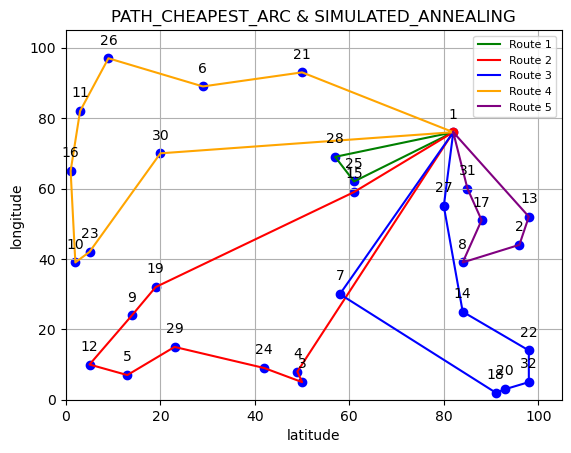

Local Search: TABU_SEARCH
Objective: 796
Route for vehicle 1:
 1 Load(0) ->  28 Load(20) ->  25 Load(44) ->  0 Load(44)
Distance of the route: 59m
Load of the route: 44

Route for vehicle 2:
 1 Load(0) ->  4 Load(6) ->  3 Load(27) ->  24 Load(35) ->  29 Load(50) ->  5 Load(69) ->  12 Load(83) ->  9 Load(89) ->  19 Load(90) ->  15 Load(93) ->  0 Load(93)
Distance of the route: 233m
Load of the route: 93

Route for vehicle 3:
 1 Load(0) ->  27 Load(2) ->  14 Load(18) ->  22 Load(30) ->  32 Load(39) ->  20 Load(63) ->  18 Load(82) ->  7 Load(94) ->  0 Load(94)
Distance of the route: 180m
Load of the route: 94

Route for vehicle 4:
 1 Load(0) ->  21 Load(8) ->  6 Load(15) ->  26 Load(39) ->  11 Load(47) ->  16 Load(69) ->  10 Load(85) ->  23 Load(89) ->  30 Load(91) ->  0 Load(91)
Distance of the route: 236m
Load of the route: 91

Route for vehicle 5:
 1 Load(0) ->  13 Load(21) ->  2 Load(40) ->  8 Load(56) ->  17 Load(74) ->  31 Load(88) ->  0 Load(88)
Distance of the route: 88m
Load of t

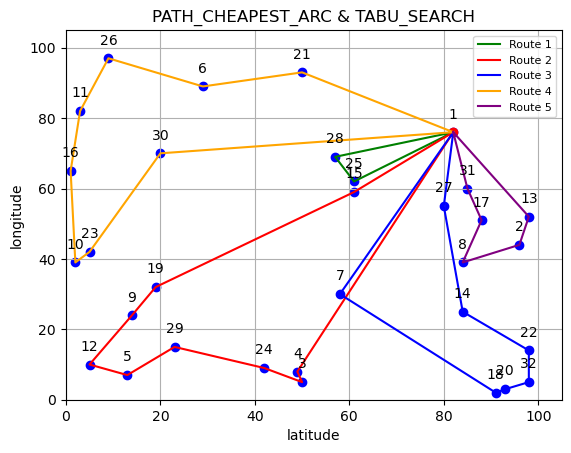

Local Search: GREEDY_DESCENT
Objective: 784
Route for vehicle 1:
 1 Load(0) ->  13 Load(21) ->  2 Load(40) ->  17 Load(58) ->  31 Load(72) ->  0 Load(72)
Distance of the route: 73m
Load of the route: 72

Route for vehicle 2:
 1 Load(0) ->  7 Load(12) ->  4 Load(18) ->  3 Load(39) ->  24 Load(47) ->  5 Load(66) ->  12 Load(80) ->  29 Load(95) ->  15 Load(98) ->  0 Load(98)
Distance of the route: 230m
Load of the route: 98

Route for vehicle 3:
 1 Load(0) ->  22 Load(12) ->  32 Load(21) ->  20 Load(45) ->  18 Load(64) ->  14 Load(80) ->  8 Load(96) ->  27 Load(98) ->  0 Load(98)
Distance of the route: 155m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  28 Load(20) ->  25 Load(44) ->  0 Load(44)
Distance of the route: 59m
Load of the route: 44

Route for vehicle 5:
 1 Load(0) ->  21 Load(8) ->  6 Load(15) ->  26 Load(39) ->  11 Load(47) ->  16 Load(69) ->  23 Load(73) ->  10 Load(89) ->  9 Load(95) ->  19 Load(96) ->  30 Load(98) ->  0 Load(98)
Distance of the route: 267m
Load

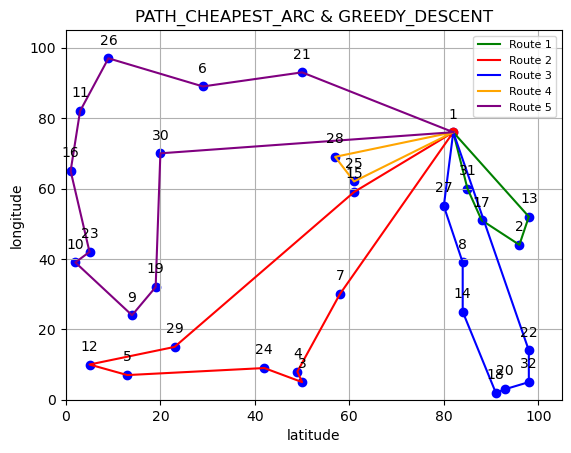

SOLUTION: SAVINGS
Local Search: SIMULATED_ANNEALING
Objective: 881
Route for vehicle 1:
 1 Load(0) ->  31 Load(14) ->  17 Load(32) ->  0 Load(32)
Distance of the route: 51m
Load of the route: 32

Route for vehicle 2:
 1 Load(0) ->  7 Load(12) ->  3 Load(33) ->  14 Load(49) ->  2 Load(68) ->  13 Load(89) ->  0 Load(89)
Distance of the route: 176m
Load of the route: 89

Route for vehicle 3:
 1 Load(0) ->  27 Load(2) ->  8 Load(18) ->  22 Load(30) ->  32 Load(39) ->  20 Load(63) ->  18 Load(82) ->  4 Load(88) ->  24 Load(96) ->  0 Load(96)
Distance of the route: 209m
Load of the route: 96

Route for vehicle 4:
 1 Load(0) ->  21 Load(8) ->  6 Load(15) ->  26 Load(39) ->  11 Load(47) ->  30 Load(49) ->  28 Load(69) ->  25 Load(93) ->  0 Load(93)
Distance of the route: 186m
Load of the route: 93

Route for vehicle 5:
 1 Load(0) ->  16 Load(22) ->  23 Load(26) ->  10 Load(42) ->  12 Load(56) ->  5 Load(75) ->  29 Load(90) ->  9 Load(96) ->  19 Load(97) ->  15 Load(100) ->  0 Load(100)
Distanc

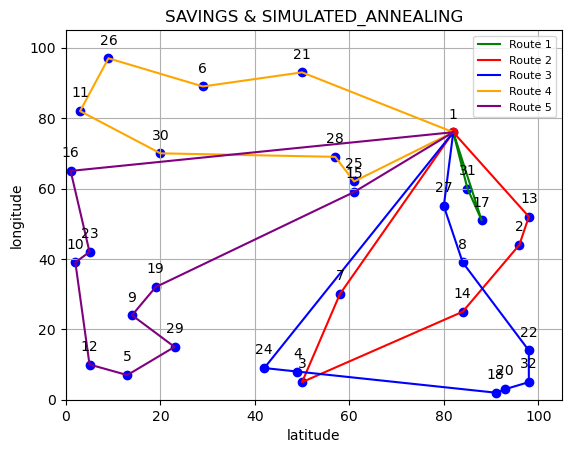

Local Search: TABU_SEARCH
Objective: 784
Route for vehicle 1:
 1 Load(0) ->  21 Load(8) ->  6 Load(15) ->  26 Load(39) ->  11 Load(47) ->  16 Load(69) ->  23 Load(73) ->  10 Load(89) ->  9 Load(95) ->  19 Load(96) ->  30 Load(98) ->  0 Load(98)
Distance of the route: 267m
Load of the route: 98

Route for vehicle 2:
 1 Load(0) ->  7 Load(12) ->  3 Load(33) ->  4 Load(39) ->  24 Load(47) ->  5 Load(66) ->  12 Load(80) ->  29 Load(95) ->  15 Load(98) ->  0 Load(98)
Distance of the route: 230m
Load of the route: 98

Route for vehicle 3:
 1 Load(0) ->  22 Load(12) ->  32 Load(21) ->  20 Load(45) ->  18 Load(64) ->  14 Load(80) ->  8 Load(96) ->  27 Load(98) ->  0 Load(98)
Distance of the route: 155m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  25 Load(24) ->  28 Load(44) ->  0 Load(44)
Distance of the route: 59m
Load of the route: 44

Route for vehicle 5:
 1 Load(0) ->  13 Load(21) ->  2 Load(40) ->  17 Load(58) ->  31 Load(72) ->  0 Load(72)
Distance of the route: 73m
Load of

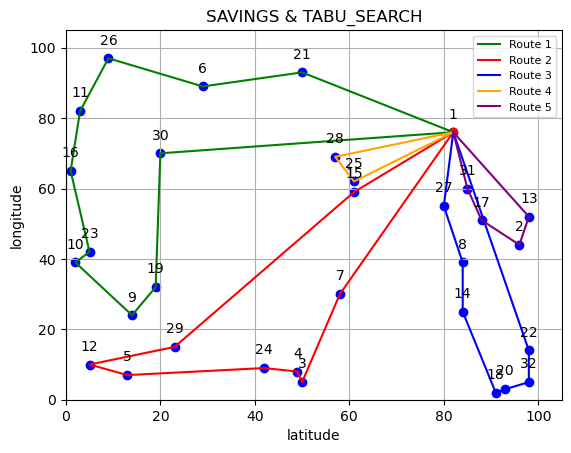

Local Search: GREEDY_DESCENT
Objective: 784
Route for vehicle 1:
 1 Load(0) ->  13 Load(21) ->  2 Load(40) ->  17 Load(58) ->  31 Load(72) ->  0 Load(72)
Distance of the route: 73m
Load of the route: 72

Route for vehicle 2:
 1 Load(0) ->  7 Load(12) ->  4 Load(18) ->  3 Load(39) ->  24 Load(47) ->  5 Load(66) ->  12 Load(80) ->  29 Load(95) ->  15 Load(98) ->  0 Load(98)
Distance of the route: 230m
Load of the route: 98

Route for vehicle 3:
 1 Load(0) ->  22 Load(12) ->  32 Load(21) ->  20 Load(45) ->  18 Load(64) ->  14 Load(80) ->  8 Load(96) ->  27 Load(98) ->  0 Load(98)
Distance of the route: 155m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  25 Load(24) ->  28 Load(44) ->  0 Load(44)
Distance of the route: 59m
Load of the route: 44

Route for vehicle 5:
 1 Load(0) ->  21 Load(8) ->  6 Load(15) ->  26 Load(39) ->  11 Load(47) ->  16 Load(69) ->  23 Load(73) ->  10 Load(89) ->  9 Load(95) ->  19 Load(96) ->  30 Load(98) ->  0 Load(98)
Distance of the route: 267m
Load

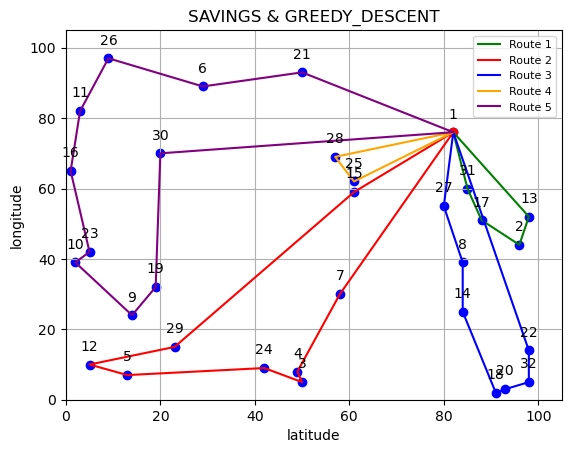

SOLUTION: CHRISTOFIDES
Local Search: SIMULATED_ANNEALING
Objective: 784
Route for vehicle 1:
 1 Load(0) ->  13 Load(21) ->  2 Load(40) ->  17 Load(58) ->  31 Load(72) ->  0 Load(72)
Distance of the route: 73m
Load of the route: 72

Route for vehicle 2:
 1 Load(0) ->  7 Load(12) ->  4 Load(18) ->  3 Load(39) ->  24 Load(47) ->  5 Load(66) ->  12 Load(80) ->  29 Load(95) ->  15 Load(98) ->  0 Load(98)
Distance of the route: 230m
Load of the route: 98

Route for vehicle 3:
 1 Load(0) ->  22 Load(12) ->  32 Load(21) ->  20 Load(45) ->  18 Load(64) ->  14 Load(80) ->  8 Load(96) ->  27 Load(98) ->  0 Load(98)
Distance of the route: 155m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  25 Load(24) ->  28 Load(44) ->  0 Load(44)
Distance of the route: 59m
Load of the route: 44

Route for vehicle 5:
 1 Load(0) ->  21 Load(8) ->  6 Load(15) ->  26 Load(39) ->  11 Load(47) ->  16 Load(69) ->  23 Load(73) ->  10 Load(89) ->  9 Load(95) ->  19 Load(96) ->  30 Load(98) ->  0 Load(98)
Dist

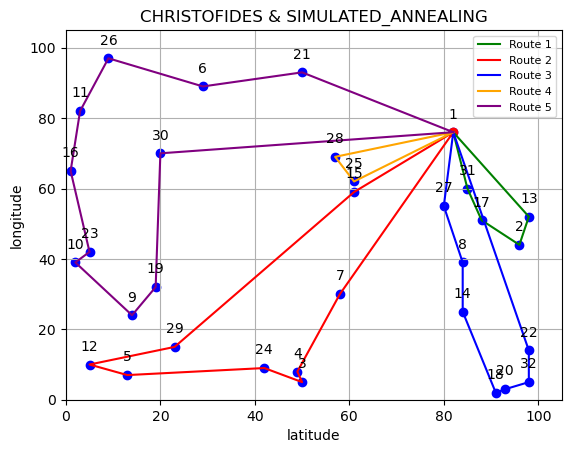

Local Search: TABU_SEARCH
Objective: 784
Route for vehicle 1:
 1 Load(0) ->  25 Load(24) ->  28 Load(44) ->  0 Load(44)
Distance of the route: 59m
Load of the route: 44

Route for vehicle 2:
 1 Load(0) ->  7 Load(12) ->  3 Load(33) ->  4 Load(39) ->  24 Load(47) ->  5 Load(66) ->  12 Load(80) ->  29 Load(95) ->  15 Load(98) ->  0 Load(98)
Distance of the route: 230m
Load of the route: 98

Route for vehicle 3:
 1 Load(0) ->  27 Load(2) ->  8 Load(18) ->  14 Load(34) ->  18 Load(53) ->  20 Load(77) ->  32 Load(86) ->  22 Load(98) ->  0 Load(98)
Distance of the route: 155m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  21 Load(8) ->  6 Load(15) ->  26 Load(39) ->  11 Load(47) ->  16 Load(69) ->  23 Load(73) ->  10 Load(89) ->  9 Load(95) ->  19 Load(96) ->  30 Load(98) ->  0 Load(98)
Distance of the route: 267m
Load of the route: 98

Route for vehicle 5:
 1 Load(0) ->  13 Load(21) ->  2 Load(40) ->  17 Load(58) ->  31 Load(72) ->  0 Load(72)
Distance of the route: 73m
Load of 

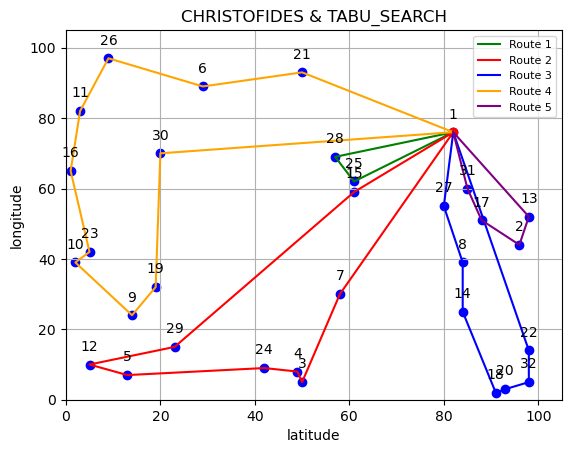

Local Search: GREEDY_DESCENT
Objective: 796
Route for vehicle 1:
 1 Load(0) ->  25 Load(24) ->  28 Load(44) ->  0 Load(44)
Distance of the route: 59m
Load of the route: 44

Route for vehicle 2:
 1 Load(0) ->  4 Load(6) ->  3 Load(27) ->  24 Load(35) ->  29 Load(50) ->  5 Load(69) ->  12 Load(83) ->  9 Load(89) ->  19 Load(90) ->  15 Load(93) ->  0 Load(93)
Distance of the route: 233m
Load of the route: 93

Route for vehicle 3:
 1 Load(0) ->  27 Load(2) ->  14 Load(18) ->  22 Load(30) ->  32 Load(39) ->  20 Load(63) ->  18 Load(82) ->  7 Load(94) ->  0 Load(94)
Distance of the route: 180m
Load of the route: 94

Route for vehicle 4:
 1 Load(0) ->  21 Load(8) ->  6 Load(15) ->  26 Load(39) ->  11 Load(47) ->  16 Load(69) ->  10 Load(85) ->  23 Load(89) ->  30 Load(91) ->  0 Load(91)
Distance of the route: 236m
Load of the route: 91

Route for vehicle 5:
 1 Load(0) ->  13 Load(21) ->  2 Load(40) ->  8 Load(56) ->  17 Load(74) ->  31 Load(88) ->  0 Load(88)
Distance of the route: 88m
Load o

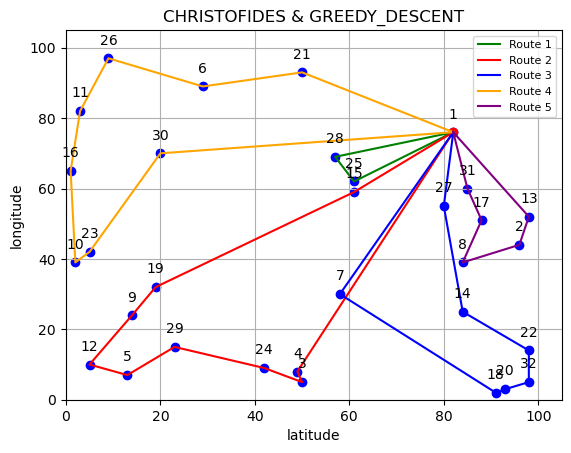

SOLUTION: PARALLEL_CHEAPEST_INSERTION
Local Search: SIMULATED_ANNEALING
Objective: 796
Route for vehicle 1:
 1 Load(0) ->  25 Load(24) ->  28 Load(44) ->  0 Load(44)
Distance of the route: 59m
Load of the route: 44

Route for vehicle 2:
 1 Load(0) ->  4 Load(6) ->  3 Load(27) ->  24 Load(35) ->  29 Load(50) ->  5 Load(69) ->  12 Load(83) ->  9 Load(89) ->  19 Load(90) ->  15 Load(93) ->  0 Load(93)
Distance of the route: 233m
Load of the route: 93

Route for vehicle 3:
 1 Load(0) ->  27 Load(2) ->  14 Load(18) ->  22 Load(30) ->  32 Load(39) ->  20 Load(63) ->  18 Load(82) ->  7 Load(94) ->  0 Load(94)
Distance of the route: 180m
Load of the route: 94

Route for vehicle 4:
 1 Load(0) ->  30 Load(2) ->  23 Load(6) ->  10 Load(22) ->  16 Load(44) ->  11 Load(52) ->  26 Load(76) ->  6 Load(83) ->  21 Load(91) ->  0 Load(91)
Distance of the route: 236m
Load of the route: 91

Route for vehicle 5:
 1 Load(0) ->  13 Load(21) ->  2 Load(40) ->  8 Load(56) ->  17 Load(74) ->  31 Load(88) ->  0 

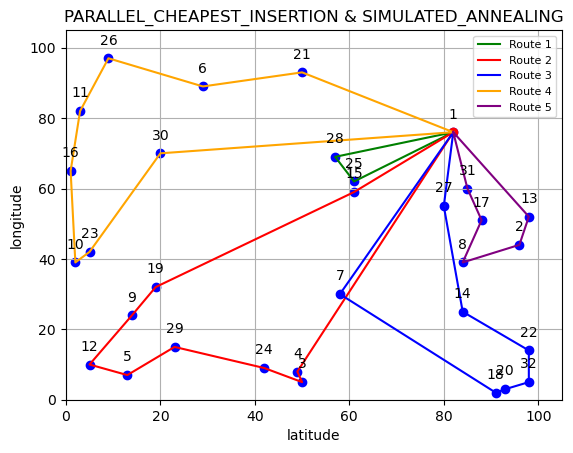

Local Search: TABU_SEARCH
Objective: 880
Route for vehicle 1:
 1 Load(0) ->  21 Load(8) ->  6 Load(15) ->  26 Load(39) ->  11 Load(47) ->  16 Load(69) ->  23 Load(73) ->  30 Load(75) ->  28 Load(95) ->  0 Load(95)
Distance of the route: 230m
Load of the route: 95

Route for vehicle 2:
 1 Load(0) ->  27 Load(2) ->  7 Load(14) ->  3 Load(35) ->  29 Load(50) ->  5 Load(69) ->  12 Load(83) ->  10 Load(99) ->  19 Load(100) ->  0 Load(100)
Distance of the route: 255m
Load of the route: 100

Route for vehicle 3:
 1 Load(0) ->  14 Load(16) ->  22 Load(28) ->  32 Load(37) ->  20 Load(61) ->  18 Load(80) ->  4 Load(86) ->  24 Load(94) ->  9 Load(100) ->  0 Load(100)
Distance of the route: 252m
Load of the route: 100

Route for vehicle 4:
 1 Load(0) ->  15 Load(3) ->  25 Load(27) ->  0 Load(27)
Distance of the route: 55m
Load of the route: 27

Route for vehicle 5:
 1 Load(0) ->  13 Load(21) ->  2 Load(40) ->  8 Load(56) ->  17 Load(74) ->  31 Load(88) ->  0 Load(88)
Distance of the route: 88m
Loa

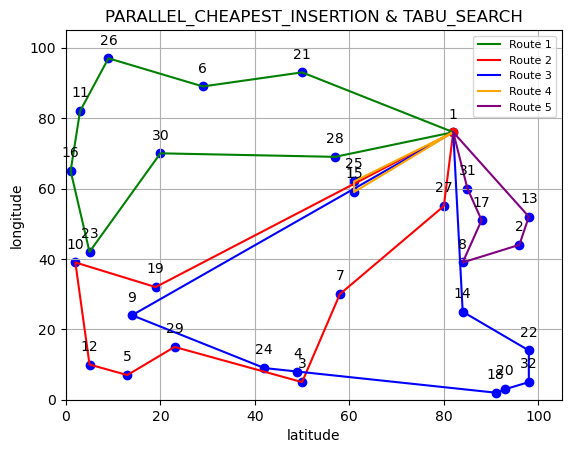

Local Search: GREEDY_DESCENT
Objective: 784
Route for vehicle 1:
 1 Load(0) ->  13 Load(21) ->  2 Load(40) ->  17 Load(58) ->  31 Load(72) ->  0 Load(72)
Distance of the route: 73m
Load of the route: 72

Route for vehicle 2:
 1 Load(0) ->  7 Load(12) ->  4 Load(18) ->  3 Load(39) ->  24 Load(47) ->  5 Load(66) ->  12 Load(80) ->  29 Load(95) ->  15 Load(98) ->  0 Load(98)
Distance of the route: 230m
Load of the route: 98

Route for vehicle 3:
 1 Load(0) ->  22 Load(12) ->  32 Load(21) ->  20 Load(45) ->  18 Load(64) ->  14 Load(80) ->  8 Load(96) ->  27 Load(98) ->  0 Load(98)
Distance of the route: 155m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  25 Load(24) ->  28 Load(44) ->  0 Load(44)
Distance of the route: 59m
Load of the route: 44

Route for vehicle 5:
 1 Load(0) ->  21 Load(8) ->  6 Load(15) ->  26 Load(39) ->  11 Load(47) ->  16 Load(69) ->  23 Load(73) ->  10 Load(89) ->  9 Load(95) ->  19 Load(96) ->  30 Load(98) ->  0 Load(98)
Distance of the route: 267m
Load

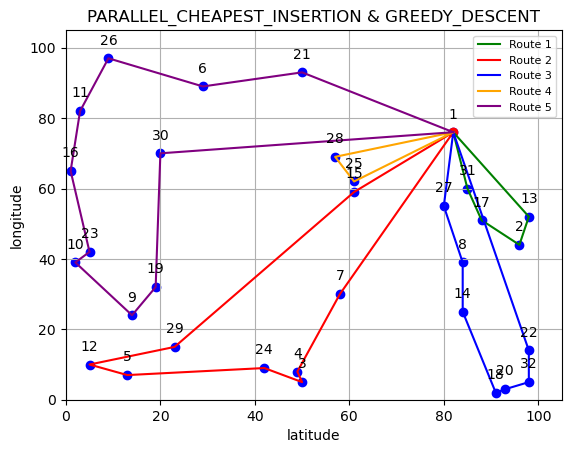

In [17]:
total_distance= 0
# def main():
"""Solve the CVRP problem."""
# Instantiate the data problem.
data = create_data_model(distance_matrix, demand_section, capacity, num_vehicl)
sol = []
#debug
#     for row in data['distance_matrix']:
#         print(row)
#     print("Demands:")
#     print(data['demands'])
#     print("Vehicle Capacities:")
#     print(data['vehicle_capacities'])
#     print("Number of Vehicles:")
#     print(data['num_vehicles'])
#     print("Depot:")
#     print(data['depot'])

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                               data['num_vehicles'], data['depot'])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)


# Create and register a transit callback.
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Add Capacity constraint.
def demand_callback(from_index):
    """Returns the demand of the node."""
    # Convert from routing variable Index to demands NodeIndex.
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(
demand_callback)
routing.AddDimensionWithVehicleCapacity(
demand_callback_index,
0,  # null capacity slack
data['vehicle_capacities'],  # vehicle maximum capacities
True,  # start cumul to zero
'Capacity')


# Setting first solution heuristic.
# search_parameters = pywrapcp.DefaultRoutingSearchParameters()
# search_parameters.first_solution_strategy = (
# routing_enums_pb2.FirstSolutionStrategy.AUTOMATIC)
# search_parameters.local_search_metaheuristic = (
# routing_enums_pb2.LocalSearchMetaheuristic.AUTOMATIC)
# search_parameters.time_limit.FromSeconds(1)

def apply_euristic(FS, LSM, time_limit=10):
    #Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = getattr(routing_enums_pb2.FirstSolutionStrategy, FS)
    search_parameters.local_search_metaheuristic = getattr(routing_enums_pb2.LocalSearchMetaheuristic, LSM)
    search_parameters.time_limit.FromSeconds(1)

    return search_parameters


def solve_routing_problem(FS,LSM):
    #INIZIO TEMPO CALCOLO
    start_time = time.time()
    search_parameters = apply_euristic(FS, LSM)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    end_time = time.time()
    execution_time = end_time - start_time
    #FINE TEMPO CALCOLO
    
    
    # Print solution on console.
    if solution:
        total_distance = print_solution(data, manager, routing, solution,execution_time)
        
    #debug
    #print("DEBUG PROVA:", total_distance)

    #Plotto le route della soluzione sul grafico
    get_routes_from_solution(solution,FS,LSM)
    result=(total_distance, execution_time,FS,LSM)
    sol.append(result)
    

FS = ["PATH_CHEAPEST_ARC", "SAVINGS", "CHRISTOFIDES", "PARALLEL_CHEAPEST_INSERTION"]
LSM = ["SIMULATED_ANNEALING","TABU_SEARCH","GREEDY_DESCENT"]

for i in range(len(FS)):
    print("SOLUTION:", FS[i])
    for j in range(len(LSM)):
        print("Local Search:", LSM[j])
        solve_routing_problem(FS[i],LSM[j])

#debug   
#print (sol)
    
# if __name__ == '__main__':
#     main()

In [50]:
file_path = "Istanza_A\A-n32-k5.sol"  # Specifica il percorso relativo del file .vrp
with open(file_path, "r") as file:
    # Leggi il contenuto del file
    file_content = file.read()
    print(file_content)

Route #1: 21 31 19 17 13 7 26
Route #2: 12 1 16 30
Route #3: 27 24
Route #4: 29 18 8 9 22 15 10 25 5 20
Route #5: 14 28 11 4 23 3 2 6
Cost 784



In [51]:
# Leggi il file e analizza le righe
with open(file_path, "r") as file:
    for line in file:
        line = line.strip()
        if line.startswith("Cost"):
            sol_opt = int(''.join(filter(str.isdigit, line)))
            break
            
print("Soluzione ottima:",sol_opt)

Soluzione ottima: 784


In [52]:
#Valutazione del gap per ogni algoritmo
gap = []
print("Soluzione ottima:",sol_opt)
for ris in sol:
    print("Algoritmo utilizzato:",ris[2])
    print("Opzione di ricerca locale:",ris[3])
    print("Soluzione:",ris[0])
    local_gap=abs((sol_opt - ris[0] )) / abs(sol_opt) * 100
    gap.append(local_gap)
    print(f"Gap: {local_gap}%")
    #Tempo di esecuzione
    print('Tempo di esecuzione: {}s'.format(ris[1]))
    print('----------------------------------------')

Soluzione ottima: 784
Algoritmo utilizzato: PATH_CHEAPEST_ARC
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 796
Gap: 1.530612244897959%
Tempo di esecuzione: 0.999967098236084s
----------------------------------------
Algoritmo utilizzato: PATH_CHEAPEST_ARC
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 796
Gap: 1.530612244897959%
Tempo di esecuzione: 1.0000317096710205s
----------------------------------------
Algoritmo utilizzato: PATH_CHEAPEST_ARC
Opzione di ricerca locale: GREEDY_DESCENT
Soluzione: 801
Gap: 2.1683673469387754%
Tempo di esecuzione: 1.0009660720825195s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 784
Gap: 0.0%
Tempo di esecuzione: 0.9999697208404541s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 784
Gap: 0.0%
Tempo di esecuzione: 0.9990360736846924s
----------------------------------------
Algorit

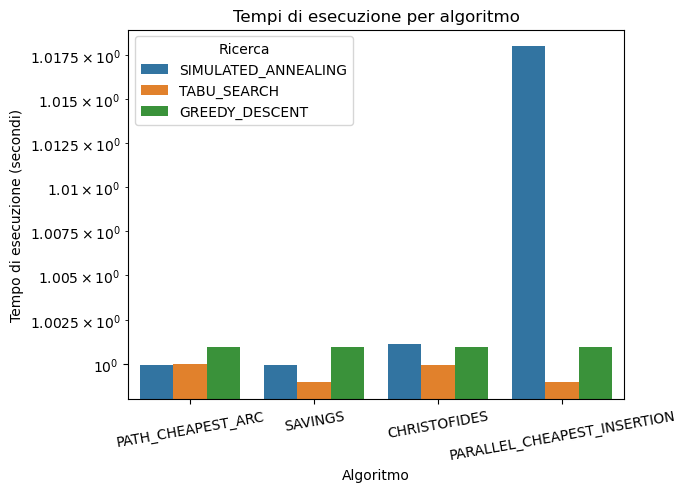

In [53]:
# Creazione delle liste per i tempi di esecuzione e gli algoritmi
execution_times = []
algorithms = []
search = []
solutions= []
# Iterazione attraverso i risultati per riempire le liste dei tempi di esecuzione e degli algoritmi
for result in sol:
    carico = result[0]
    tempo = result[1]
    algoritmo = result[2]
    ricerca = result[3]
    
    solutions.append(carico)
    execution_times.append(tempo)
    algorithms.append(algoritmo)
    search.append(ricerca)
    
# Creazione del DataFrame
data = pd.DataFrame({'Algoritmo': algorithms, 'Tempo di esecuzione': execution_times, 'Ricerca':search })

# Creazione del barplot con Seaborn
sns.barplot(x='Algoritmo', y='Tempo di esecuzione', data=data, hue= "Ricerca")
plt.title('Tempi di esecuzione per algoritmo')
plt.xlabel('Algoritmo')
plt.ylabel('Tempo di esecuzione (secondi)')
plt.yscale('log')

# Rimpicciolire i nomi degli algoritmi
plt.xticks(rotation=10, fontsize=10)

# Mostra il grafico
plt.show()


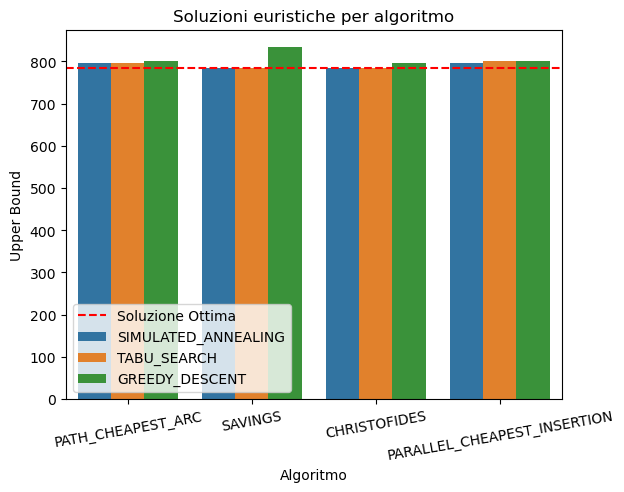

In [55]:
# Creazione del DataFrame
data = pd.DataFrame({'Algoritmo': algorithms, 'UB': solutions, 'Ricerca':search })

# Creazione del barplot con Seaborn
sns.barplot(x='Algoritmo', y='UB', data=data, hue= "Ricerca")
plt.title('Soluzioni euristiche per algoritmo')
plt.xlabel('Algoritmo')
plt.ylabel('Upper Bound')
# Aggiungi una linea orizzontale per rappresentare l'ottimo
plt.axhline(y=sol_opt, color='red', linestyle='--', label='Soluzione Ottima')

# Rimpicciolire i nomi degli algoritmi
plt.xticks(rotation=10, fontsize=10)

plt.legend()

# Mostra il grafico
plt.show()

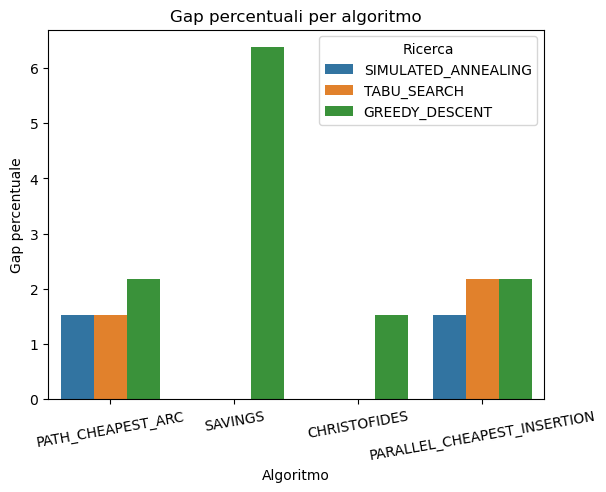

In [56]:
# Creazione del DataFrame
data = pd.DataFrame({'Algoritmo': algorithms, 'Gap': gap, 'Ricerca':search })

# Creazione del barplot con Seaborn
sns.barplot(x='Algoritmo', y='Gap', data=data, hue= "Ricerca")
plt.title('Gap percentuali per algoritmo')
plt.xlabel('Algoritmo')
plt.ylabel('Gap percentuale')

# Rimpicciolire i nomi degli algoritmi
plt.xticks(rotation=10, fontsize=10)

# Mostra il grafico
plt.show()
